## Here we run several unconstrained classifiers on the COMPAS dataset and look at the avg social welfare of their predictions

Import necessary dependencies.
Note that the modules "load_compas_data_modified", "utils" and "funcs_disp_mist_modified" are adopted from "Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment" by Zafar et. al.

In [23]:
import numpy as np
import pandas as pd
from load_compas_data_modified  import *
import funcs_disp_mist_modified as fdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import utils_modified as ut
import sklearn as skl
from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network
import operator

### Defining a utility function

In [2]:
def eval_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = sum(np.power((np.subtract(y_pred,y_actual)+10),alpha))
    return s/n 

### Defining functions to compute violations w.r.t. individual Fairness constraints

For the generalized entropy measure of Speicher et al a constant (they call is alpha) is needed, we use 2 and therefore call the measure GE2

In [3]:
# x1 and x2 are feature vectors, we use euclidian distance
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def avg_Dwork_violation(y_pred, X_data):
    # go trough all pairs of predictions and see if constraints are violated
    violation_sum = 0
    n = y_pred.shape[0]
    assert(X_data.shape[0] == n)
    for i in range(n):
        for j in range(i+1,n):
            violation_sum += np.maximum(0, np.absolute(y_pred[i] - y_pred[j]) - distance(X_data[i,:],X_data[j,:]))
    return 2*violation_sum/(n*(n-1))
    
# y_pred and y_actual are vectors of predictions
# return value is a scalar
def ge2(y_pred, y_actual):
    benefit = (np.subtract(y_pred,y_actual)+1)
    mu = np.average(benefit)
    return 0.5*np.average(np.power(benefit/mu,2)) - 0.5

## Importing the COMPAS dataset

Here we import the COMPAS dataset. It is preprocessed the same way as in the ProPublica study (refer to https://github.com/propublica/compas-analysis)

In [4]:
#data_type = 1
X, y, x_control = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 



We will test logistic regression, a linear SVM, an SVM with rbf kernel and a MLP
All models are taken from the sklearn library and run with default parameters

In [27]:
# fairness measures to track
dwork_dict = {'logreg': 0.0, 'linsvm': 0.0, 'rbfsvm': 0.0,'mlp': 0.0}
ge_dict = {'logreg': 0.0, 'linsvm': 0.0, 'rbfsvm': 0.0,'mlp': 0.0}
utility_dict = {'logreg': 0.0, 'linsvm': 0.0, 'rbfsvm': 0.0,'mlp': 0.0}
accuracy_dict = {'logreg': 0.0, 'linsvm': 0.0, 'rbfsvm': 0.0,'mlp': 0.0}

cross_val_iter = 10
alpha = 1

for i in range(0,cross_val_iter):
    print(print("#############cross validation iteration " + str(i) + " #########################"))
    """permute the date randomly"""
    perm = list(range(0,X.shape[0]))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    #for k in list(x_control.keys()):
    for k in x_control.keys():
        x_control[k] = x_control[k][perm]

    """ Split the data into train and test """
    train_fold_size = 1 - 1/cross_val_iter
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)
    print("train fold size: " + str(train_fold_size))
    num_points, num_features = x_train.shape
    
    # logistic regression
    logreg = linear_model.LogisticRegression()
    logreg.fit(x_train,y_train)
    y_logreg_pred = logreg.predict(x_test)
    dwork_dict['logreg'] += avg_Dwork_violation(y_logreg_pred,x_test)
    ge_dict['logreg'] += ge2(y_logreg_pred, y_test)
    utility_dict['logreg'] += eval_util(y_logreg_pred, y_test, alpha)
    accuracy_dict['logreg'] += logreg.score(x_test,y_test)

    #linear svm
    linsvm = svm.SVC(kernel='linear')
    linsvm.fit(x_train,y_train)
    y_linsvm_pred = linsvm.predict(x_test)
    dwork_dict['linsvm'] += avg_Dwork_violation(y_linsvm_pred,x_test)
    ge_dict['linsvm'] += ge2(y_linsvm_pred, y_test)
    utility_dict['linsvm'] += eval_util(y_linsvm_pred, y_test, alpha)
    accuracy_dict['linsvm'] += linsvm.score(x_test,y_test)
    
    #rbf svm
    rbfsvm = svm.SVC(kernel='rbf')
    rbfsvm.fit(x_train,y_train)
    y_rbfsvm_pred = rbfsvm.predict(x_test)
    dwork_dict['rbfsvm'] += avg_Dwork_violation(y_rbfsvm_pred,x_test)
    ge_dict['rbfsvm'] += ge2(y_rbfsvm_pred, y_test)
    utility_dict['rbfsvm'] += eval_util(y_rbfsvm_pred, y_test, alpha)
    accuracy_dict['rbfsvm'] += rbfsvm.score(x_test,y_test)
    
    #mlp
    mlp = neural_network.MLPClassifier()
    mlp.fit(x_train,y_train)
    y_mlp_pred = mlp.predict(x_test)
    dwork_dict['mlp'] += avg_Dwork_violation(y_mlp_pred,x_test)
    ge_dict['mlp'] += ge2(y_mlp_pred, y_test)
    utility_dict['mlp'] += eval_util(y_mlp_pred, y_test, alpha)
    accuracy_dict['mlp'] += mlp.score(x_test,y_test)
    
# notice that you have to divide every dict value by cross_val_iter to get the real value
dwork_dict = {k: v / cross_val_iter for k, v in dwork_dict.items()}
ge_dict = {k: v / cross_val_iter for k, v in ge_dict.items()}
utility_dict = {k: v / cross_val_iter for k, v in utility_dict.items()}
accuracy_dict = {k: v / cross_val_iter for k, v in accuracy_dict.items()}

print("dwork:")
print(dwork_dict)
print("ge2:")
print(ge_dict)
print("social welfare")
print(utility_dict)
print("accuracy:")
print(accuracy_dict)

#############cross validation iteration 0 #########################
None
train fold size: 0.9
#############cross validation iteration 1 #########################
None
train fold size: 0.9
#############cross validation iteration 2 #########################
None
train fold size: 0.9
#############cross validation iteration 3 #########################
None
train fold size: 0.9
#############cross validation iteration 4 #########################
None
train fold size: 0.9
#############cross validation iteration 5 #########################
None
train fold size: 0.9
#############cross validation iteration 6 #########################
None
train fold size: 0.9
#############cross validation iteration 7 #########################
None
train fold size: 0.9
#############cross validation iteration 8 #########################
None
train fold size: 0.9
#############cross validation iteration 9 #########################
None
train fold size: 0.9
dwork:
{'logreg': 0.10136854044471907, 'linsvm': 0.086015350

save the data generated

In [28]:
accuracy_saved = accuracy_dict
dwork_saved = dwork_dict
ge_saved = ge_dict
utility_saved = utility_dict

### create sorted bar graphs of the models

First we sort the dictionaries

In [32]:
sorted_accuracy = dict(sorted(accuracy_saved.items(), key=operator.itemgetter(1), reverse=True))
sorted_dwork = dict(sorted(dwork_saved.items(), key=operator.itemgetter(1)))
sorted_ge = dict(sorted(ge_saved.items(), key=operator.itemgetter(1)))
sorted_utility = dict(sorted(utility_saved.items(), key=operator.itemgetter(1), reverse=True))

{'logreg': 0.6617424242424242, 'linsvm': 0.6486742424242424, 'rbfsvm': 0.6606060606060606, 'mlp': 0.6659090909090909}
{'logreg': 0.10136854044471907, 'linsvm': 0.08601535012480858, 'rbfsvm': 0.10776133049427587, 'mlp': 0.11228341857365531}
{'logreg': 0.8348220094879621, 'linsvm': 0.8389596414904904, 'rbfsvm': 0.7796633558663368, 'mlp': 0.7468180531873168}
{'logreg': 9.899999999999999, 'linsvm': 9.916287878787879, 'rbfsvm': 9.93560606060606, 'mlp': 9.95}
{'mlp': 0.6659090909090909, 'logreg': 0.6617424242424242, 'rbfsvm': 0.6606060606060606, 'linsvm': 0.6486742424242424}
{'linsvm': 0.08601535012480858, 'logreg': 0.10136854044471907, 'rbfsvm': 0.10776133049427587, 'mlp': 0.11228341857365531}
{'mlp': 0.7468180531873168, 'rbfsvm': 0.7796633558663368, 'logreg': 0.8348220094879621, 'linsvm': 0.8389596414904904}
{'mlp': 9.95, 'rbfsvm': 9.93560606060606, 'linsvm': 9.916287878787879, 'logreg': 9.899999999999999}


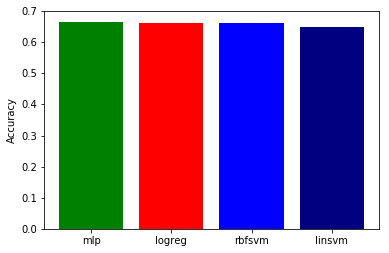

In [36]:
index = np.arange(4)
mlp, log, rbf, lin = plt.bar(index,sorted_accuracy.values())
log.set_facecolor('r')
lin.set_facecolor('navy')
rbf.set_facecolor('b')
mlp.set_facecolor('g')

plt.ylabel("Accuracy")
plt.xticks(index, sorted_accuracy.keys())
plt.show()

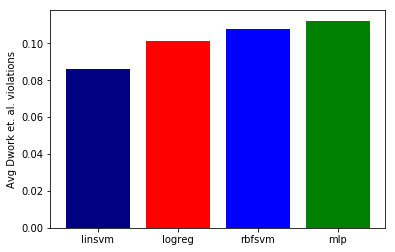

In [38]:
index = np.arange(4)
lin, log, rbf, mlp = plt.bar(index,sorted_dwork.values())
log.set_facecolor('r')
lin.set_facecolor('navy')
rbf.set_facecolor('b')
mlp.set_facecolor('g')

plt.ylabel("Avg Dwork et. al. violations")
plt.xticks(index, sorted_dwork.keys())
plt.show()

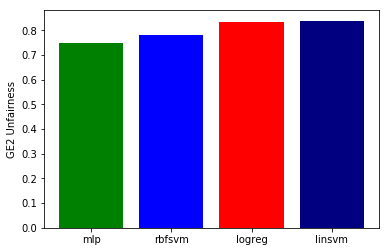

In [39]:
index = np.arange(4)
mlp, rbf, log, lin = plt.bar(index,sorted_ge.values())
log.set_facecolor('r')
lin.set_facecolor('navy')
rbf.set_facecolor('b')
mlp.set_facecolor('g')

plt.ylabel("GE2 Unfairness")
plt.xticks(index, sorted_ge.keys())
plt.show()

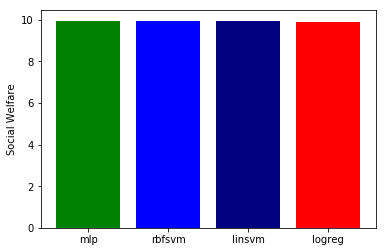

In [41]:
index = np.arange(4)
mlp, rbf, lin, log = plt.bar(index,sorted_utility.values())
log.set_facecolor('r')
lin.set_facecolor('navy')
rbf.set_facecolor('b')
mlp.set_facecolor('g')

plt.ylabel("Social Welfare")
plt.xticks(index, sorted_utility.keys())
plt.show()

Saving the output to files

In [46]:
np.save('Accuracy_dict.npy', accuracy_saved)
np.save('Dwork_dict.npy', dwork_saved) 
np.save('GE_dict.npy', ge_saved) 
np.save('Utility_dict.npy', utility_saved) 